In [1]:

import tensorflow as tf
from tensorflow import keras
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)


TensorFlow version: 2.2.0
Keras version: 2.3.0-tf


In [2]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GRU,LSTM,Bidirectional
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing import image
import tensorflow.keras.callbacks
import cv2

# Get alphabet

In [3]:
from collections import Counter
def get_counter(dirpath):
    dirname = os.path.basename(dirpath)
    ann_dirpath = join(dirpath, 'ann')
    letters = ''
    lens = []
    for filename in os.listdir(ann_dirpath):
        json_filepath = join(ann_dirpath, filename)
        description = json.load(open(json_filepath, 'r'))['description']
        lens.append(len(description))
        letters += description
    print('Max plate length in "%s":' % dirname, max(Counter(lens).keys()))
    return Counter(letters)
c_val = get_counter('./test')
c_train = get_counter('./train/')
letters_train = set(c_train.keys())
letters_val = set(c_val.keys())
if letters_train == letters_val:
    print('Letters in train and val do match')
else:
    raise Exception()
# print(len(letters_train), len(letters_val), len(letters_val | letters_train))
letters = sorted(list(letters_train))
print('Letters:', ' '.join(letters))

Max plate length in "test": 8
Max plate length in "": 8
Letters in train and val do match
Letters: 0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


# Input data generator

In [4]:
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

class TextImageGenerator:
    
    def __init__(self, 
                 dirpath, 
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=8):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        self.samples = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext == '.png':
                img_filepath = join(img_dirpath, filename)
                json_filepath = join(ann_dirpath, name + '.json')
                description = json.load(open(json_filepath, 'r'))['description']
                if is_valid_str(description):
                    self.samples.append([img_filepath, description])
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)
        
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [5]:

tiger = TextImageGenerator('./train/', 128, 64, 8, 4)
tiger.build_data()

Text generator output (data which will be fed into the neutral network):
1) the_input (image)


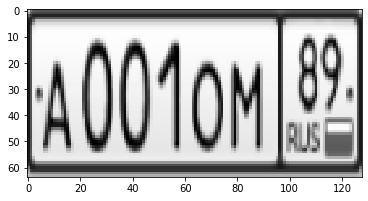

2) the_labels (plate number): A001OM89 is encoded as [10, 0, 0, 1, 17, 16, 8, 9]
3) input_length (width of image that is fed to the loss function): 30 == 128 / 4 - 2
4) label_length (length of plate number): 8


In [6]:
for inp, out in tiger.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    print('1) the_input (image)')
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (plate number): %s is encoded as %s' % 
          (labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))))
    print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][0], tiger.img_w))
    print('4) label_length (length of plate number): %d' % inp['label_length'][0])
    break

# Loss and train functions, network architecture

In [7]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def train(img_w, load=False):
    
    # Input Parameters
    img_h = 64

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        
    batch_size = 32
    downsample_factor = pool_size ** 2
    tiger_train = TextImageGenerator('./train/', img_w, img_h, batch_size, downsample_factor)
    tiger_train.build_data()
    tiger_val = TextImageGenerator('./test/', img_w, img_h, batch_size, downsample_factor)
    tiger_val.build_data()

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = LSTM(rnn_size, return_sequences=True,  name='gru1')
    gru_1b = LSTM(rnn_size, return_sequences=True, go_backwards=True, name='gru1_b')
    gru1_merged = Bidirectional(gru_1, backward_layer=gru_1b )(inner)
    gru_2 = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')
    gru_2b = LSTM(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')
    gru2_merged = Bidirectional(gru_2, backward_layer=gru_2b )(gru1_merged)
    # transforms RNN output to character activations:
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(gru2_merged)
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
#     sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    sgd=Adam()
    if load:
        model = load_model('./tmp_model.h5', compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if not load:
        # captures output of softmax so we can decode the output during visualization
        test_func = K.function([input_data], [y_pred])

        model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.n,
                            epochs=1, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.n)

    return model

In [8]:
model = train(128, load=False)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 64, 16)       160       
_________________________________________________________________
max1 (MaxPooling2D)          (None, 64, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 32, 16)        2320      
_________________________________________________________________
max2 (MaxPooling2D)          (None, 32, 16, 16)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 256)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 32)            8224  

In [9]:
model.save('model_nomer.h5', include_optimizer=False)

In [20]:
# model = tf.keras.models.load_model('model_nomer.h5', compile=False)

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
____________________________________________________________________________________________

In [21]:
extracted_layers = model.layers[:-4]

In [22]:
model1 = keras.Sequential(extracted_layers)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 128, 64, 16)       160       
_________________________________________________________________
max1 (MaxPooling2D)          (None, 64, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 32, 16)        2320      
_________________________________________________________________
max2 (MaxPooling2D)          (None, 32, 16, 16)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 256)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 32)            8224      
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 1024)          2

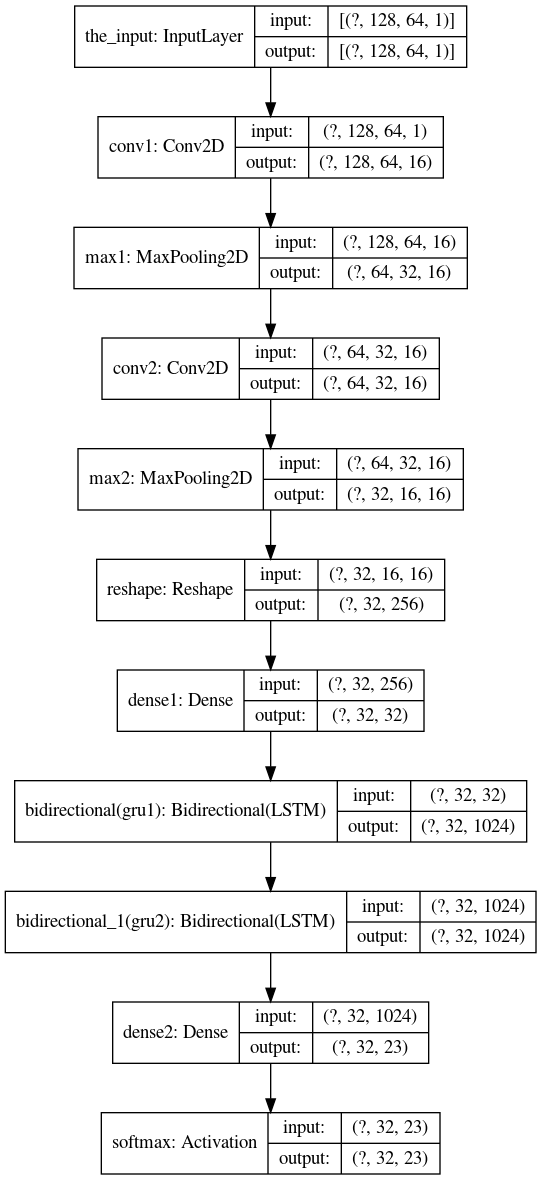

In [13]:
tf.keras.utils.plot_model(model1, 'multi_input_and_output_model.png', show_shapes=True)

# Function to decode neural network output

In [14]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

# Test on validation images

Predicted: A036CT78
True: A036CT78


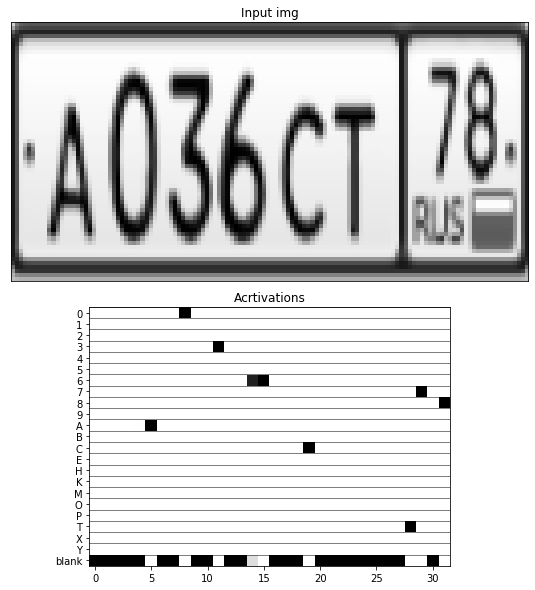

Predicted: A065CA30
True: A065CA30


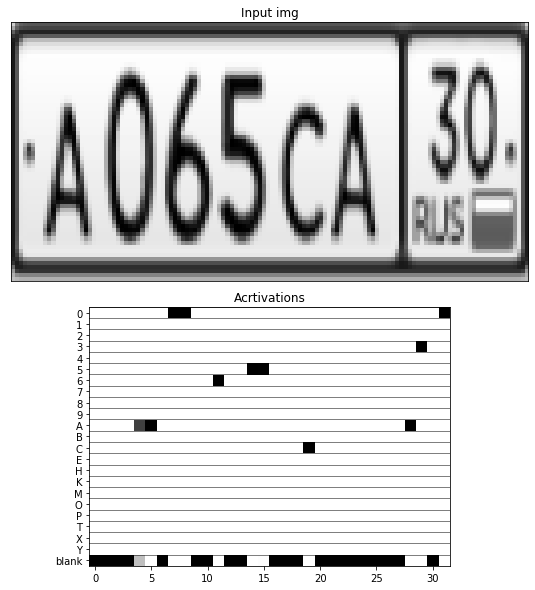

Predicted: A083YA10
True: A083YA10


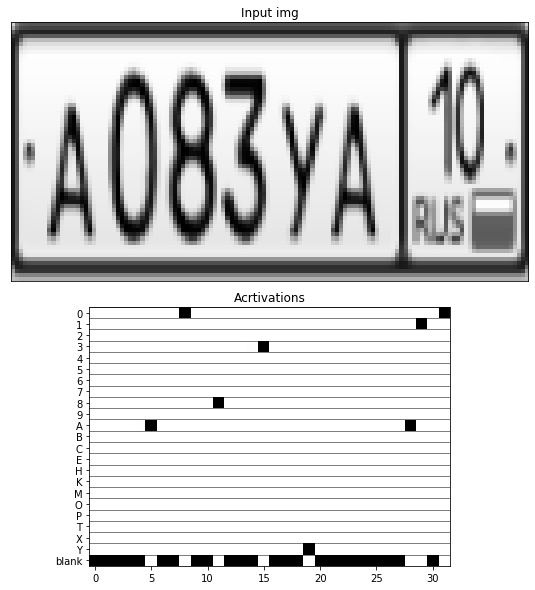

Predicted: A128HB61
True: A128HB61


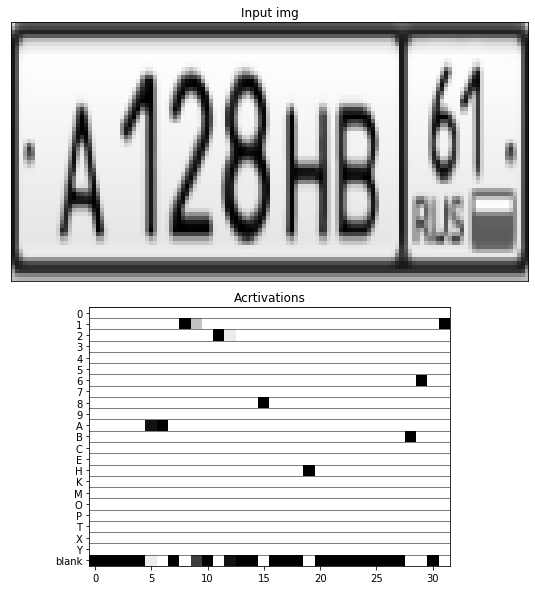

Predicted: A141AP01
True: A141AP01


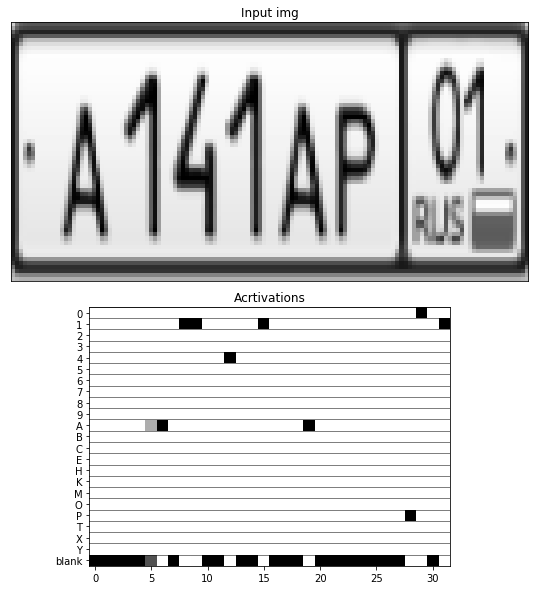

Predicted: A160HE95
True: A160HE95


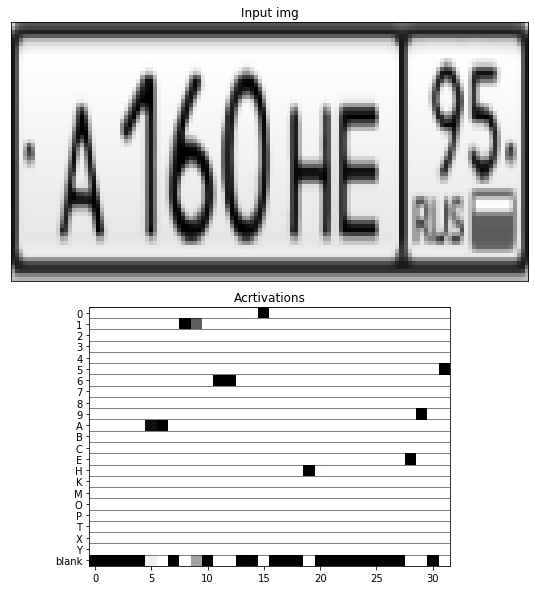

Predicted: A183KE05
True: A183KE05


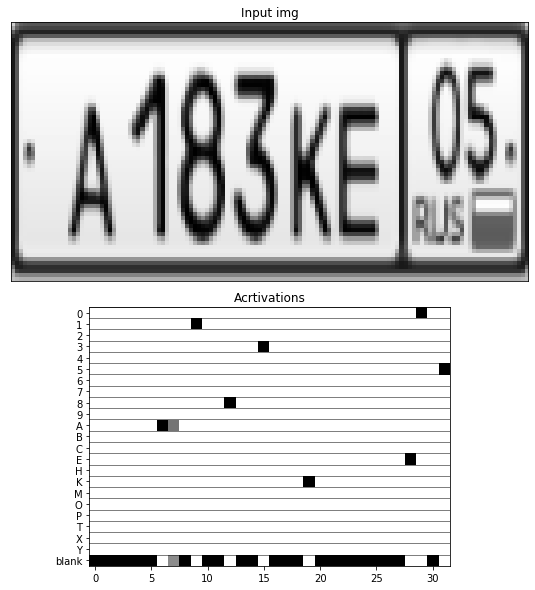

Predicted: A225EP73
True: A225EP73


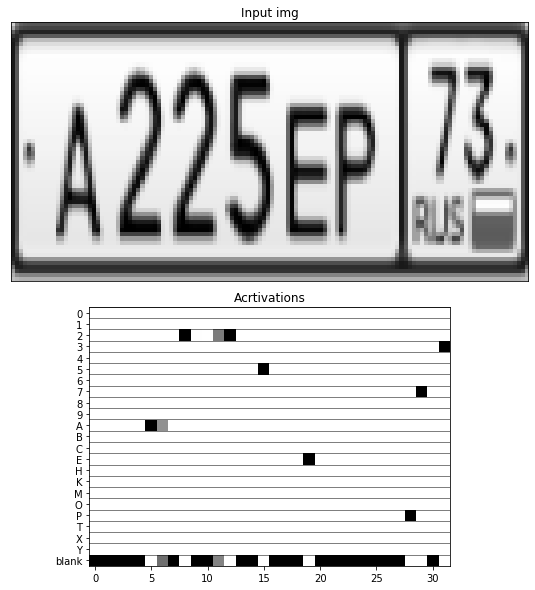

In [15]:
tiger_test = TextImageGenerator('./test/', 128, 64, 8, 4)
tiger_test.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in tiger_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
#     net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    net_out_value=model1.predict(X_data)
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Acrtivations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break

In [16]:
X_data.shape

(8, 128, 64, 1)

In [23]:
run_model = tf.function(lambda x: model1(x))
concrete_func = run_model.get_concrete_function(
            tf.TensorSpec([1,128, 64,1], model1.inputs[0].dtype))
MODEL_DIR = "keras_num"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

INFO:tensorflow:Assets written to: keras_num/assets


INFO:tensorflow:Assets written to: keras_num/assets


In [ ]:
# tf.compat.v1.reset_default_graph()

# tflite convert

In [25]:
MODEL_DIR = "keras_num"
# model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open('./model1_nomer.tflite',"wb").write(tflite_model)

34391504

# Test tflite model

In [30]:
paths='./model1_nomer.tflite'
interpreter = tf.lite.Interpreter(model_path=paths)
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


load image

In [31]:
img = cv2.imread('./test/img/A007HA50.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128,64))
img = img.astype(np.float32)
img /= 255
# # width and height are backwards from typical Keras convention
# because width is the time dimension when it gets fed into the RNN
img1=img.T
img1.shape

(128, 64)

In [32]:
X_data1=np.float32(img1.reshape(1,128, 64,1))
input_index = (interpreter.get_input_details()[0]['index'])
interpreter.set_tensor(input_details[0]['index'], X_data1)

interpreter.invoke()

net_out_value = interpreter.get_tensor(output_details[0]['index'])
pred_texts = decode_batch(net_out_value)
pred_texts

['A007HA50']

Predicted: A007HA50


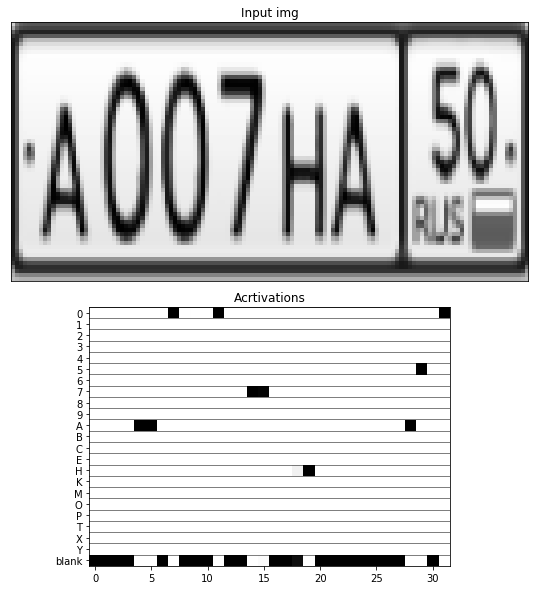

In [33]:
fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
ax1 = plt.Subplot(fig, outer[0])
fig.add_subplot(ax1)
ax2 = plt.Subplot(fig, outer[1])
fig.add_subplot(ax2)
print('Predicted:', pred_texts[0])
img = X_data1[0,:, :, 0].T
ax1.set_title('Input img')
ax1.imshow(img, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_title('Acrtivations')
ax2.imshow(net_out_value[0].T, cmap='binary', interpolation='nearest')
ax2.set_yticks(list(range(len(letters) + 1)))
ax2.set_yticklabels(letters + ['blank'])
ax2.grid(False)
for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
    ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)

#ax.axvline(x, linestyle='--', color='k')
plt.show()